## Semantic Segmentation
### 1. DeepLab 모델준비

In [1]:
import cv2
import numpy as np
import os
import tarfile
import urllib
from matplotlib import pyplot as plt
import tensorflow as tf

In [2]:
# 준비한 이미지를 읽는다. 
import os
img_path = '/aiffel/aiffel/lms_project_dataset/EP8/ice_cream.png'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

(4032, 3024, 3)


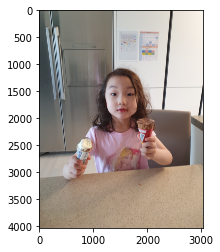

In [3]:
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [4]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

In [5]:
# 사전에 학습된 가중치(pretrained weight)를 불러옵니다. 구글에서 제공하는 파일을 다운로드하겠습니다.
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = '/aiffel/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /aiffel/aiffel/human_segmentation/models
model loaded successfully!


In [6]:
# 첫 단계에서 준비한 이미지를 네트워크에 입력합니다.
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(4032, 3024, 3) (513, 384, 3) 15


In [7]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

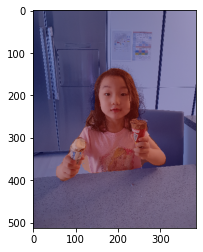

In [8]:
# 사람영역만 검출해내고, 마스크 만들고 시각화
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

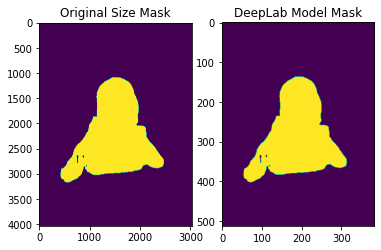

In [9]:
# 세그멘테이션 결과(mask)를 원래 크기로 복원해 보겠습니다.
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up)#, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask)#, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

In [10]:
# 개선사항: Original Size Mask와 DeepLab Model Mask의 인물안에 점이 보이는 부분을 수정하는 것. 
# CNN의 Maxpooling을 이용해서 이미지안의 점을 지우려는 계획( 이미지 출력 방법 해결 못함.)

## 2. 배경 블러 처리하고 배경 합성하기 

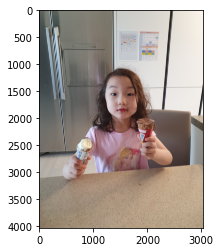

In [11]:
# 배경 흐리게 하기(전체)
img_orig_blur = cv2.blur(img_orig, (13,13)) #(13,13)은 blurring  kernel size를 뜻합니다. 
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

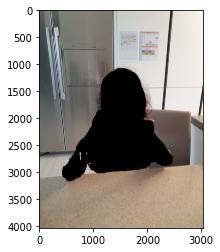

In [12]:
# 흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출하겠습니다.
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR) # 원본=흰색,주변=검은색
img_bg_mask = cv2.bitwise_not(img_mask_color) # 이미지 반전시킴: 원본=검은색,주변=흰색
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask) #배경만있는 이미지. 
#img_bg_mask가 인물검은색이기 때문에, 인물은 and에서 빠짐-> 배경만있는 이미지
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

# img_mask_up: (원본사이즈) 내부 노랑색/ 외부 짙은보라 
# img_mask: (줄어든 사이즈) 내부 노랑색/ 외부 짙은보라 
# img_orig_blur: 블러시킨(색깔도 좀 바뀜) 전체 사진 

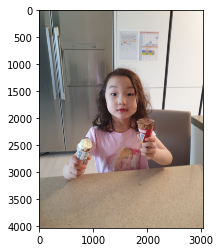

In [13]:
# 이제 배경 영상과 사람 영상을 합치기
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

## 프로젝트 정리 
- DeepLab, CV2 등 필요한 기능들을 적재적소에 잘 가져다가 쓸 수 있는 능력이 필요하다고 중요하다는 생각을 다시금 하게 됨.
- 사람영역을 검출한 이미지를 보면, 사람영역 안에 점이 생기거나, 경계가 매끄럽지 못한 문제점들이 발견됨. 이러한 부분의 처리가 필요함. 